## Loading the data

In [38]:
import numpy as np
import scanpy as sc
from adjustText import adjust_text
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec

import os 

sc.set_figure_params(dpi=100, frameon=False)
sc.logging.print_header()

scanpy==1.7.1 anndata==0.7.5 umap==0.5.1 numpy==1.19.2 scipy==1.6.1 pandas==1.2.3 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.8.3 leidenalg==0.8.3


In [39]:
os.getcwd()

'/home/mo/projects/test_AdvAE/Norman_results'

In [40]:
os.chdir("../")

In [41]:
%load_ext autoreload
%autoreload 2

In [42]:
adata = sc.read('./datasets/Norman2019_prep_new.h5ad')

In [44]:
adata.obs.condition.unique()

['ctrl', 'TSC22D1+ctrl', 'KLF1+MAP2K6', 'CEBPE+RUNX1T1', 'MAML2+ctrl', ..., 'SNAI1+ctrl', 'PLK4+STIL', 'ZBTB10+ELMSAN1', 'CDKN1C+ctrl', 'C3orf72+FOXL2']
Length: 284
Categories (284, object): ['ctrl', 'TSC22D1+ctrl', 'KLF1+MAP2K6', 'CEBPE+RUNX1T1', ..., 'PLK4+STIL', 'ZBTB10+ELMSAN1', 'CDKN1C+ctrl', 'C3orf72+FOXL2']

## Loading the model

In [6]:
os.getcwd()

'/home/mo/projects/test_AdvAE'

In [7]:
import torch
from compert.train import prepare_compert

state, args, metrics = torch.load('./pretrained_models/Norman2019_prep_new_deg_collect/relu/sweep_Norman2019_prep_new_relu_model_seed=16_epoch=80.pt', map_location=torch.device('cuda'))
args['dataset_path'] = './datasets/Norman2019_prep_new.h5ad'
args['save_dir'] = '/ckpts'
model, datasets = prepare_compert(args, state_dict=state)

In [8]:
args

{'dataset_path': './datasets/Norman2019_prep_new.h5ad',
 'perturbation_key': 'condition',
 'dose_key': 'dose_val',
 'cell_type_key': 'cell_type',
 'split_key': 'split',
 'loss_ae': 'gauss',
 'doser_type': 'linear',
 'decoder_activation': 'ReLU',
 'seed': 16,
 'hparams': '',
 'max_epochs': 2000,
 'max_minutes': 300,
 'patience': 20,
 'checkpoint_freq': 20,
 'save_dir': '/ckpts',
 'sweep_seeds': 200}

In [9]:
%%time
from compert.data import load_dataset_splits

datasets, full_dataset = load_dataset_splits(
    dataset_path=args['dataset_path'],
    perturbation_key=args['perturbation_key'],
    dose_key=args['dose_key'],
    cell_type_key=args['cell_type_key'],
    split_key = args["split_key"],
    return_dataset=True)  

CPU times: user 39.1 s, sys: 2.09 s, total: 41.2 s
Wall time: 38.2 s


In [10]:
from compert.plotting import CompertVisuals
from compert.api import ComPertAPI

In [11]:
compert_api = ComPertAPI(datasets, model)

Print and plot drug embeddings.

In [12]:
perts_anndata = compert_api.get_drug_embeddings()
perts_anndata

AnnData object with n_obs × n_vars = 106 × 256
    obs: 'condition'

In [13]:
condition_key = "condition"

In [14]:
drug_emb_FC = dict(zip(perts_anndata.obs["condition"].tolist(),perts_anndata.X))

combining embeddings

In [15]:
drug_comb_fc = {}
for i in np.unique(adata.obs[condition_key]):
    split = i.split("+")
    temp = np.zeros(perts_anndata.shape[1])
    for j in split:
        temp += drug_emb_FC[j]
    drug_comb_fc[i] = temp

In [16]:
adata_comb = sc.AnnData(X=np.array(list(drug_comb_fc.values())))
adata_comb.obs[condition_key] = list(drug_comb_fc.keys())

In [17]:
g1_cycle = ['CDKN1A+ctrl',
 'CDKN1B+CDKN1A',
 'CDKN1B+ctrl',
 'CDKN1C+CDKN1A',
 'CDKN1C+CDKN1B',
 'CDKN1C+ctrl']
ERYTHROID = ['CBL+CNN1',
 'CBL+PTPN12',
 'CBL+PTPN9',
 'CBL+UBASH3B',
 'SAMD1+PTPN12',
 'SAMD1+UBASH3B','UBASH3B+CNN1',
 'UBASH3B+PTPN12',
 'UBASH3B+PTPN9',
 'UBASH3B+UBASH3A',
 'UBASH3B+ZBTB25',
 'BPGM+SAMD1',
'PTPN1+ctrl',
 'PTPN12+PTPN9',
 'PTPN12+UBASH3A',
 'PTPN12+ZBTB25',]
PIONEER_FACTORS = ['FOXA1+FOXF1',
 'FOXA1+FOXL2',
 'FOXA1+HOXB9',
 'FOXA3+FOXA1',
 'FOXA3+FOXF1',
 'FOXA3+FOXL2',
 'FOXA3+HOXB9',
 'FOXA3+ctrl',
 'FOXF1+FOXL2',
 'FOXF1+HOXB9',
 'FOXL2+MEIS1',
 'HOXA13+ctrl',
 'HOXC13+ctrl',]
GRANULOCYTE_APOPTOSIS = ['ctrl+SPI1', 'SPI1+ctrl','CEBPA+ctrl',
 'CEBPB+CEBPA',
 'CEBPB+MAPK1',
 'CEBPB+ctrl',
 'CEBPE+CEBPA',
 'CEBPE+CEBPB',
 'CEBPE+RUNX1T1',
 'CEBPE+SPI1',
 'CEBPE+ctrl',
 'ETS2+CEBPE',
 'ctrl+CEBPE',
 'ctrl+CEBPA'
'KLF1+CEBPA'
'FOSB+CEBPB',
 'FOSB+CEBPE',
]
PRO_GROWTH = ['CEBPE+KLF1',
             'ctrl+KLF1',
              'KLF1+BAK1',
             'KLF1+CEBPA',
             'KLF1+COL2A1',
             'KLF1+MAP2K6',
             'KLF1+TGFBR2',
             'KLF1+ctrl',
              'AHR+KLF1']
MEGAKARYOCYTE = ['MAPK1+IKZF3',
 'MAPK1+PRTG',
 'MAPK1+TGFBR2',
 'MAPK1+ctrl',
 'ctrl+MAPK1',
 'ETS2+MAPK1',
 'ctrl+ETS2']

In [18]:
anotated_ko = MEGAKARYOCYTE + PRO_GROWTH + GRANULOCYTE_APOPTOSIS + PIONEER_FACTORS + ERYTHROID + g1_cycle

In [19]:
sc.pp.neighbors(adata_comb,n_neighbors=6, metric="cosine",use_rep='X')
sc.tl.leiden(adata_comb, resolution=0.7)

In [20]:
sc.tl.umap(adata_comb)

In [21]:
umap_combo = dict(zip(adata_comb.obs[condition_key], adata_comb.obsm['X_umap']))

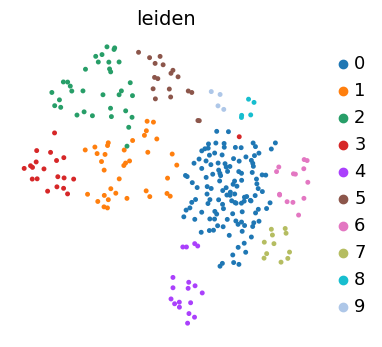

In [22]:
sc.pl.umap(adata_comb, color="leiden", size=50)

In [23]:
def plot_latent(drug_emb_pca, #dictionary of embedding coordinates
                col_dict=None, #dictionary for dots color, default='dark gray'
                col_dict_pathway=None, 
                current_palette=None, #palette for the drugs
                plot_drug_list=['control'], #names of drugs to put on the plot
                title='Drug latent space',
                bold_names=['control', 'ctrl'], #names of drugs to be desplayed in bold font
                col_dict_face=None, #dictionary for text color, default='black'
                fs=9, # fontsize for text
                s1=8.5, s2=6, #figure size in inches
                fname=None,
                plotline=False, #set true if you want to see vectors from 0
                format='png'):
    
    sns.set_style("whitegrid", {'axes.grid' : False})

    atomic_drugs = list(drug_emb_pca.keys())
    
    if col_dict is None:
        if current_palette is None:
            current_palette = ['#636363']*len(atomic_drugs)
        col_dict = dict(zip(atomic_drugs, current_palette[:len(atomic_drugs)]))

    if col_dict_face is None:
        col_dict_face = dict(zip(atomic_drugs, ['#000000']*len(atomic_drugs)))
    
    fig = plt.figure(figsize=(s1, s2))
    gs = gridspec.GridSpec(1, 2, width_ratios=[7, 1])
    ax = plt.subplot(gs[0])
    ax.grid('off')
    ax.axis('off')
    for i, drug in enumerate(atomic_drugs):
        if plotline:
            ax.plot([0, drug_emb_pca[drug][0]], [0, drug_emb_pca[drug][1]], 
                     color=col_dict[drug], alpha=0.15, linewidth=0.8)
        ax.scatter(drug_emb_pca[drug][0], drug_emb_pca[drug][1], alpha=0.9, s=10, color=col_dict[drug])

    ax.axis('equal')
    ax.grid('off')
    ax.set_title(title, fontsize=fs,fontweight="bold")
    ax.xaxis.set_tick_params(labelsize=fs)
    ax.yaxis.set_tick_params(labelsize=fs)
    sns.despine(left=True, bottom=True, right=True)
    
    texts = []
    for l, drug in enumerate(atomic_drugs):
        if drug in plot_drug_list:
            if drug in bold_names:
                texts.append(ax.text(drug_emb_pca[drug][0], drug_emb_pca[drug][1], 
                                 drug, fontsize=fs, color=col_dict_face[drug], fontweight="bold"))
            else:
                texts.append(ax.text(drug_emb_pca[drug][0], drug_emb_pca[drug][1], 
                                     drug, fontsize=fs, color=col_dict_face[drug]))
        
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black', lw=0.1))
    
    if not (col_dict_pathway is None):
        ax = plt.subplot(gs[1])
        texts = []
        eps = -1e-3
        i = 0
        mx = 0
        my = 0
        for p in col_dict_pathway.keys():
            if (p != 'Vehicle') and (p != 'NA') and (p != 'DMSO') and (p != 'control'):
                props = dict(boxstyle='round', facecolor=col_dict_pathway[p], alpha=0.6)
                texts.append(ax.text(mx + 0.5, my + i*0.045, p, fontsize=fs, 
                                      color='black', bbox=props))
                i += 1
    #     adjust_text(texts)
        ax.set_ylim([0, my  + i*0.045])
        ax.axis('off')
        sns.despine(left=True, bottom=True, right=True)

    plt.tight_layout()
    ax.grid('off')
    ax.axis('off')
    plt.show()

    if fname:
        print(fname)
        fig.savefig(f'{fname}.{format}', format=format)


In [24]:
all_colors = {k:"#DCDCDC" for k in adata.obs["condition"].unique()}

In [25]:
dict_class = {'MEGAKARYOCYTE': MEGAKARYOCYTE,
 'PRO_GROWTH': PRO_GROWTH,
 'GRANULOCYTE_APOPTOSIS': GRANULOCYTE_APOPTOSIS,
 'PIONEER_FACTORS': PIONEER_FACTORS,
 'ERYTHROID': ERYTHROID,
 'g1_cycle': g1_cycle}

In [26]:
col_dict_class = {'MEGAKARYOCYTE': '#cc79a7',
 'PRO_GROWTH': 'purple',
 'GRANULOCYTE_APOPTOSIS': 'green',
 'PIONEER_FACTORS': '#0072b2',
 'ERYTHROID': 'orange',
 'g1_cycle': 'brown'}

In [27]:
for ko in all_colors.keys():
    for ko_cls in col_dict_class.keys():
        if ko in dict_class[ko_cls]:
            all_colors[ko] = col_dict_class[ko_cls]
    

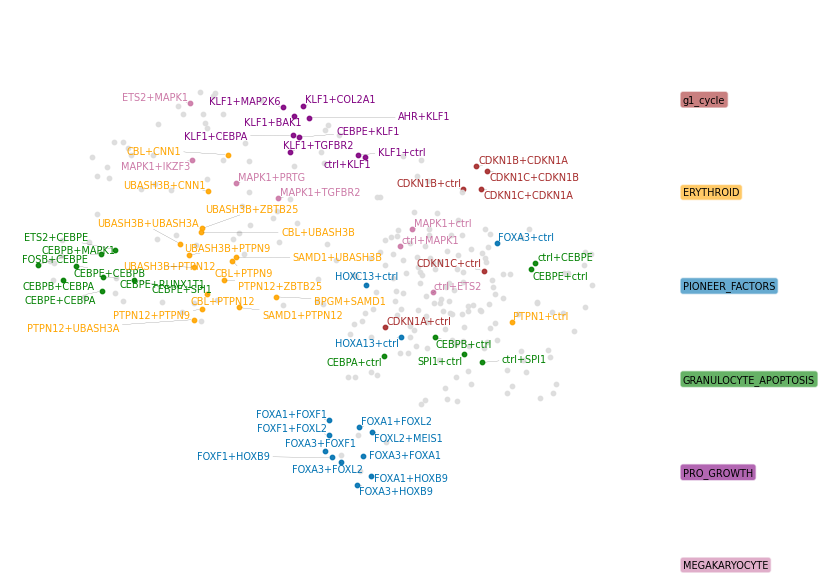

./all_2


In [28]:
plot_latent(umap_combo,
               col_dict_pathway=col_dict_class,
                plot_drug_list=anotated_ko,
                col_dict_face=all_colors,
                col_dict=all_colors,
                title="",
                plotline=False,
                 fname ="./all_2",
                fs=7,
                format="pdf")

### generate all possible combinations

In [29]:
import itertools

In [30]:
single_perturb_ids = {pi for p in adata.obs['condition'] for pi in p.split('+')}


In [31]:
unique = set(single_perturb_ids)

In [32]:
len(unique)

106

In [33]:
unique.remove("ctrl")

In [34]:
len(unique)

105

In [35]:
import itertools

In [36]:
double_ko_list = [i for i in adata.obs[condition_key].unique() if "ctrl" not in i]

In [37]:
pairs = []
for i in itertools.permutations(list(unique), 2):
   pairs.append(f"{i[0]}+{i[1]}")

In [38]:
len(pairs)

10920

In [39]:
to_generate = set(pairs).difference(double_ko_list)

In [40]:
len(double_ko_list)

131

In [41]:
len(pairs) - len(double_ko_list)

10789

In [42]:
len(to_generate)

10789

### generate all embedding for unseen combos 

In [43]:
drug_comb_fc = {}
for i in to_generate:
    split = i.split("+")
    temp = np.zeros(perts_anndata.shape[1])
    for j in split:
        temp += drug_emb_FC[j]
    drug_comb_fc[i] = temp

In [44]:
ood_embedding = sc.AnnData(X=np.array(list(drug_comb_fc.values())))
ood_embedding.obs[condition_key] = list(drug_comb_fc.keys())

In [45]:
ood_embedding.obs["type"] = ["generated"] * len(ood_embedding)

In [46]:
adata_comb

AnnData object with n_obs × n_vars = 284 × 256
    obs: 'condition', 'leiden'
    uns: 'neighbors', 'leiden', 'umap', 'leiden_colors'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

In [47]:
adata_comb.obs["type"] =  ["original data"] *len(adata_comb)

In [48]:
add_embeddings = adata_comb.concatenate(ood_embedding)

In [49]:
add_embeddings

AnnData object with n_obs × n_vars = 11073 × 256
    obs: 'condition', 'leiden', 'type', 'batch'

In [50]:
sc.pp.neighbors(add_embeddings, metric="cosine", use_rep="X")

In [51]:
sc.tl.umap(add_embeddings, )

In [52]:
sc.tl.pca(add_embeddings)

... storing 'leiden' as categorical
... storing 'type' as categorical


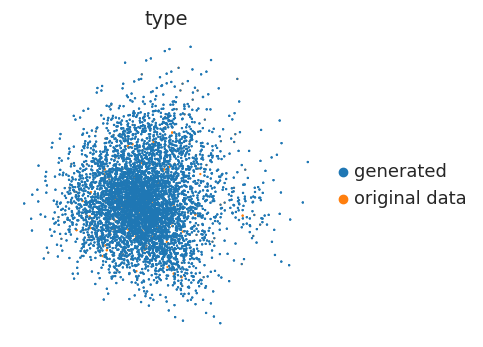

In [53]:
sc.pl.pca(add_embeddings, color="type")

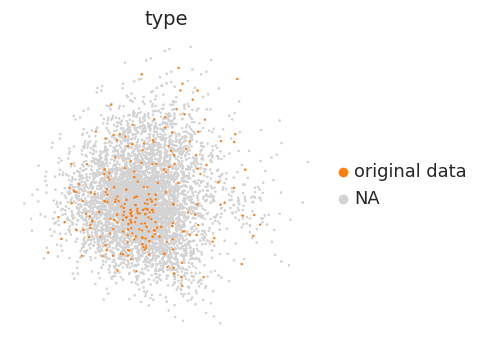

In [54]:
sc.pl.pca(add_embeddings, color="type", groups=["original data"])

In [55]:
sc.tl.leiden(add_embeddings)

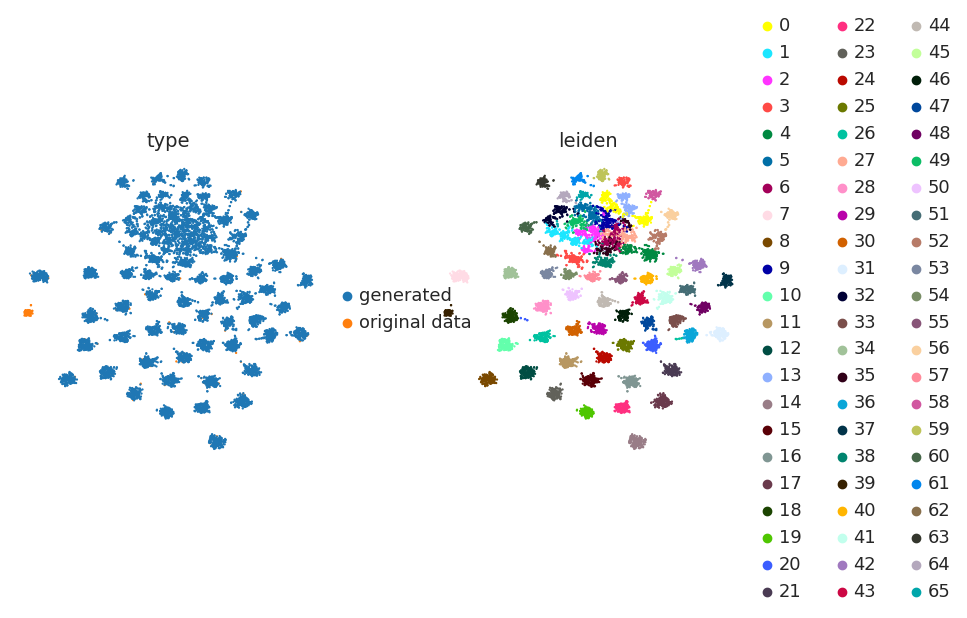

In [56]:
sc.pl.umap(add_embeddings, color=["type","leiden"])

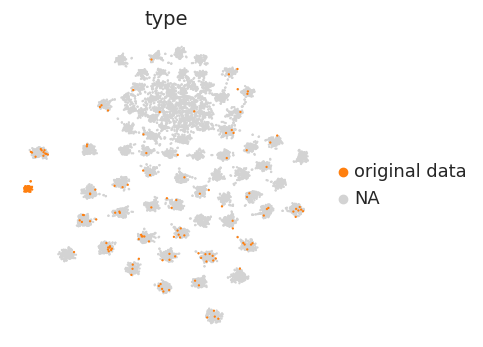

In [57]:
sc.pl.umap(add_embeddings, color="type", groups=["original data"])

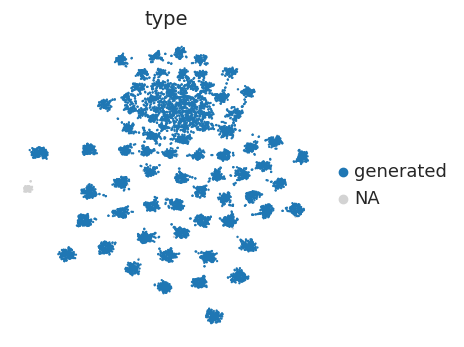

In [58]:
sc.pl.umap(add_embeddings, color="type", groups=["generated"])

In [59]:
# add_embeddings.write("./Norman_results/for_nacho/embedding_sweep_Norman2019_prep_new_relu_model_seed=16_epoch=80.h5ad")

generation

In [60]:
adata.var_names = adata.var.gene_symbols

In [61]:
torch.random.seed = 300

In [62]:
import pandas as pd

In [63]:
to_generate = list(to_generate)

In [64]:
import time

In [65]:

genes_control = full_dataset.genes[full_dataset.indices['control']]
perm = torch.randperm(genes_control.size(0),)
idx = perm[:50]
ss_ctrl = genes_control[idx]
df = pd.DataFrame({args['perturbation_key']: to_generate, 
                   args['dose_key']: ['1+1'] *len(to_generate), 
                   args['cell_type_key']: ['A549']*len(to_generate)})
start = time.time()
predicted_data = compert_api.predict(ss_ctrl, df, return_anndata=True)
end = time.time()
print(end - start)

AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([0, 1], dtype='int64'), …


53.26713514328003


In [66]:
df_ood  = predicted_data.obs.drop_duplicates(subset=[ 'condition'])

In [67]:
data_cond = list(adata.obs["condition"].unique())

In [68]:
train_cond = list(compert_api.seen_covars_perts["training"])
df = pd.DataFrame({args['perturbation_key']: data_cond,
                   args['dose_key']: ['1+1'] *len(data_cond), 
                   args['cell_type_key']: ['A549']*len(data_cond)})
predicted_data_train = compert_api.predict(ss_ctrl[0:2,:], df, return_anndata=True)

AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([0, 1], dtype='int64'), …


In [69]:
df_train = predicted_data_train.obs.drop_duplicates(subset=[ 'condition'])

In [70]:
df_all = pd.concat([df_train, df_ood])

extract uncertainty from predicted data

In [71]:
val = np.arange(len(df_all))
key = add_embeddings.obs.condition.to_list()

In [72]:
from collections import OrderedDict

In [73]:
d = OrderedDict()

In [74]:
from collections import OrderedDict

In [75]:
for i,j in zip(key,val):
    d[i] = j

In [76]:
df_all = df_all.sort_values(by="condition", key=lambda x: x.map(d))

In [77]:
df_all

,condition,dose_val,cell_type,uncertainty_cosine,uncertainty_euclidean,closest_cond_cosine,closest_cond_euclidean
0,AHR+FEV,1+1,A549,0.000000e+00,0.000000,A549_AHR+FEV_1+1,A549_AHR+FEV_1+1
0,AHR+KLF1,1+1,A549,0.000000e+00,0.000000,A549_AHR+KLF1_1+1,A549_AHR+KLF1_1+1
0,AHR+ctrl,1+1,A549,1.192093e-07,0.000000,A549_AHR+ctrl_1+1,A549_AHR+ctrl_1+1
0,ARID1A+ctrl,1+1,A549,5.960464e-08,0.000000,A549_ARID1A+ctrl_1+1,A549_ARID1A+ctrl_1+1
0,ARRDC3+ctrl,1+1,A549,0.000000e+00,0.000000,A549_ARRDC3+ctrl_1+1,A549_ARRDC3+ctrl_1+1
...,...,...,...,...,...,...,...
0,CNN1+CNNM4,1+1,A549,3.291357e-01,19.003105,A549_CNN1+MAPK1_1+1,A549_CBL+CNN1_1+1
0,PLK4+CDKN1C,1+1,A549,3.252519e-01,15.005310,A549_CDKN1C+CDKN1A_1+1,A549_CDKN1C+CDKN1A_1+1
0,PTPN1+CNNM4,1+1,A549,4.430970e-01,19.507921,A549_CNNM4+ctrl_1+1,A549_CNNM4+ctrl_1+1
0,PTPN12+MAPK1,1+1,A549,3.703184e-01,18.480253,A549_MAPK1+PRTG_1+1,A549_ZBTB10+PTPN12_1+1


In [78]:
add_embeddings

AnnData object with n_obs × n_vars = 11073 × 256
    obs: 'condition', 'leiden', 'type', 'batch'
    uns: 'neighbors', 'umap', 'pca', 'type_colors', 'leiden', 'leiden_colors'
    obsm: 'X_umap', 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [79]:
add_embeddings.obs["uncertainty_cosine"] = df_all.uncertainty_cosine.values
add_embeddings.obs["uncertainty_euclidean"] = df_all.uncertainty_euclidean.values

In [80]:
sc.pp.neighbors(add_embeddings, metric="cosine", use_rep="X")

In [81]:
sc.tl.tsne(add_embeddings)

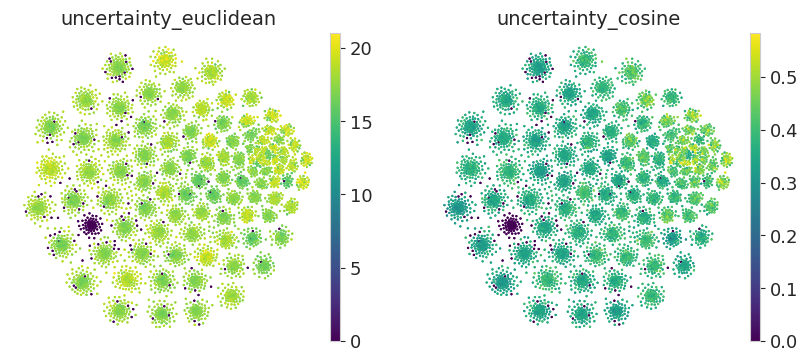

In [82]:
sc.pl.tsne(add_embeddings, color=["uncertainty_euclidean","uncertainty_cosine"], cmap="viridis")

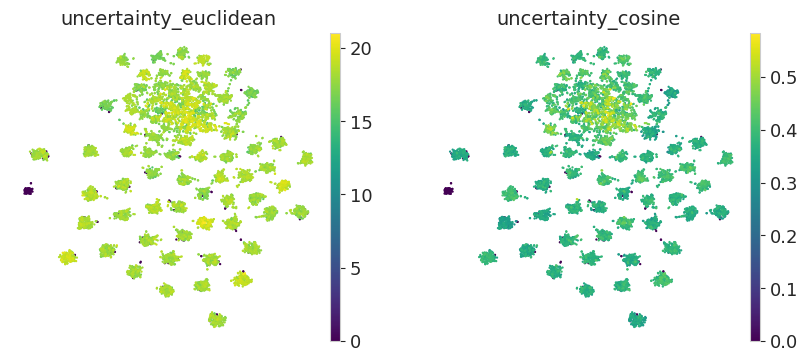

In [84]:
sc.pl.umap(add_embeddings, color=["uncertainty_euclidean","uncertainty_cosine"], cmap="viridis")

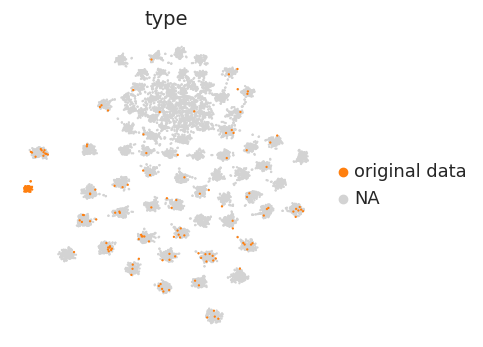

In [86]:
sc.pl.umap(add_embeddings, color="type", groups=["original data"])

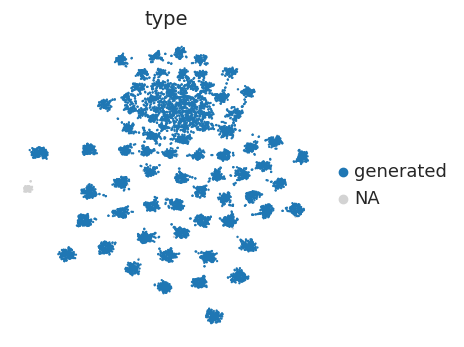

In [87]:
sc.pl.umap(add_embeddings, color="type", groups=["generated"])

In [ ]:
add_embeddings.write("./Norman_results/for_nacho/embedding_sweep_Norman2019_prep_new_relu_model_seed=16_epoch=80_12052021.h5ad")

In [103]:
predicted_data.var = adata.var

In [104]:
import pandas as pd 

In [105]:
predicted_data.obs.index.astype("category")

CategoricalIndex(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                  ...
                  '40-10788', '41-10788', '42-10788', '43-10788', '44-10788',
                  '45-10788', '46-10788', '47-10788', '48-10788', '49-10788'],
                 categories=['0', '0-1', '0-10', '0-100', '0-1000', '0-10000', '0-10001', '0-10002', ...], ordered=False, dtype='category', length=539450)

In [106]:
predicted_data.index = np.arange(len(predicted_data))

In [107]:
predicted_data.index

array([     0,      1,      2, ..., 539447, 539448, 539449])

In [108]:
predicted_data.obs.index.astype("category")

CategoricalIndex(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                  ...
                  '40-10788', '41-10788', '42-10788', '43-10788', '44-10788',
                  '45-10788', '46-10788', '47-10788', '48-10788', '49-10788'],
                 categories=['0', '0-1', '0-10', '0-100', '0-1000', '0-10000', '0-10001', '0-10002', ...], ordered=False, dtype='category', length=539450)

In [109]:
predicted_data.index = predicted_data.obs.index.astype("string")

In [110]:
predicted_data.obs.index = predicted_data.obs.index.astype("string")

In [111]:
predicted_data.obs_names_make_unique()

In [ ]:
del predicted_data.layers["variance"]

In [99]:
del predicted_data.obs["dose_val"]

In [100]:
del predicted_data.obs["cell_type"]

In [116]:
del predicted_data.var

In [117]:
predicted_data

AnnData object with n_obs × n_vars = 539450 × 5000
    obs: 'condition', 'uncertainty_cosine', 'uncertainty_euclidean', 'closest_cond_cosine', 'closest_cond_euclidean'

In [119]:
predicted_data.write("./Norman_results/for_nacho/pred_sweep_Norman2019_prep_new_relu_model_seed=16_epoch=80_120521.h5ad")

In [3]:
adata_pred = sc.read("./for_nacho/pred_sweep_Norman2019_prep_new_relu_model_seed=16_epoch=80_120521.h5ad")
from scipy.sparse import csr_matrix
adata_pred.X = csr_matrix(adata_pred.X)
adata_pred.write("./for_nacho/pred_sweep_Norman2019_prep_new_relu_model_seed=16_epoch=80_120521.h5ad")

/home/mo/miniconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [34]:
sc.

AnnData object with n_obs × n_vars = 11073 × 256
    obs: 'condition', 'leiden', 'type', 'batch', 'uncertainty_cosine', 'uncertainty_euclidean'
    uns: 'leiden', 'leiden_colors', 'neighbors', 'pca', 'type_colors', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'